# Exploring the EvalRS dataset

This notebook provides some basic EDA on the dataset of the [EvalRS 2023](https://reclist.io/kdd2023-cup/) hackathon.
Please refer to [our paper](https://arxiv.org/abs/2304.07145) for all the details.

With the goal of building a *all-around* recommender system, we likely want to understand how users, tracks and listening events are distributed, with a special case to *long tails* and rare (or new events). Yeah, you can thank us for the tip later.

Before we start, we need to check we are inside the right virtual environment

In [1]:
%%capture
# check we are using the right interpreter with the right RecList version
!which python
!pip install -r ../requirements.txt

In [1]:
import os
import sys
sys.path.insert(0, '../evaluation')

In [89]:
from EvalRSRunner import ChallengeDataset

import gc
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import pyarrow.parquet as pq

sns.set_theme("notebook")

Next, we have to download the dataset (~1.6GB) -- actually, you'll download it just the first time!

In [3]:
dataset = ChallengeDataset()

/Users/mala/Library/Caches/evalrs/evalrs_dataset_KDD_2023


evalrs_dataset_KDD_2023.zip: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1.60G/1.60G [14:55<00:00, 1.92MB/s]


Loading dataset.
Generating Train/Test Split.
Generating dataset hashes.


And get a sample fold (see details on our Bootstrapping Cross-Validation evaluation strategy to know more about folds).

In [4]:
train, test = dataset.get_sample_train_test()
train.shape, test.shape

((6902066, 6), (29725, 2))

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6902066 entries, 751 to 37926116
Data columns (total 6 columns):
 #   Column            Dtype
---  ------            -----
 0   user_id           int64
 1   artist_id         int64
 2   album_id          int64
 3   track_id          int64
 4   timestamp         int64
 5   user_track_count  int64
dtypes: int64(6)
memory usage: 368.6 MB


So. We have ~7M training listening records. Each tells us who (*user_id*) listened to what (*track_id*), when (*timestamp*), and how many times (*user_track_count*).

Let's now run some preprocessing to get started.

In [6]:
# convert the timestamp in a more convenient format
train["timestamp"] = pd.to_datetime(train["timestamp"], unit="s")

In [7]:
# add a column for Hour Of the Day
train["hod"] = train["timestamp"].dt.hour

We are ready to do some EDA.

## EDA on Tracks

Let's begin with a few statistics about tracks. We can inspect how many *unique* tracks are there! 

In [8]:
percentiles = np.arange(1, step=0.1)
gb_track = train.groupby("track_id")

**Q0: what's the Track distribution?**

In [9]:
track_records = gb_track.size()
track_records.describe(percentiles)

count    228997.000000
mean         30.140421
std          41.823156
min           8.000000
0%            8.000000
10%          10.000000
20%          12.000000
30%          13.000000
40%          15.000000
50%          17.000000
60%          21.000000
70%          26.000000
80%          36.000000
90%          59.000000
max        1585.000000
dtype: float64

There are ~230K distinct tracks. But wait. We know there is a `timestamp` feature, does that mean that a user can play the same track multiple times? Programmatically, we should check if the pair <`user`,`track`> does appear multiple times.

In [10]:
len(train.groupby(["user_id", "track_id"]).size()) == train.shape[0]

True

In [11]:
train.head()

,user_id,artist_id,album_id,track_id,timestamp,user_track_count,hod
751,50931921,3887,1168550,21882383,2014-01-08 17:07:16,1,17
752,50931921,3887,1168550,123627,2014-01-08 17:07:13,3,17
753,50931921,3887,630816,5065782,2013-12-06 18:17:02,1,18
754,50931921,279,4451359,37612,2013-12-01 11:33:44,1,11
755,50931921,4166,29770,85498,2013-11-17 11:53:59,1,11


The two sizes correspond: we can assume there are no <`user`,`track`> duplicates. Indeed, the `user_track_count` value lets us know the play count!

We also obtained a new information: `track_records` contains the number of distinct users that played a given track. Let's now observe the distribution graphically.

Text(0, 0.5, 'Track Count (log)')

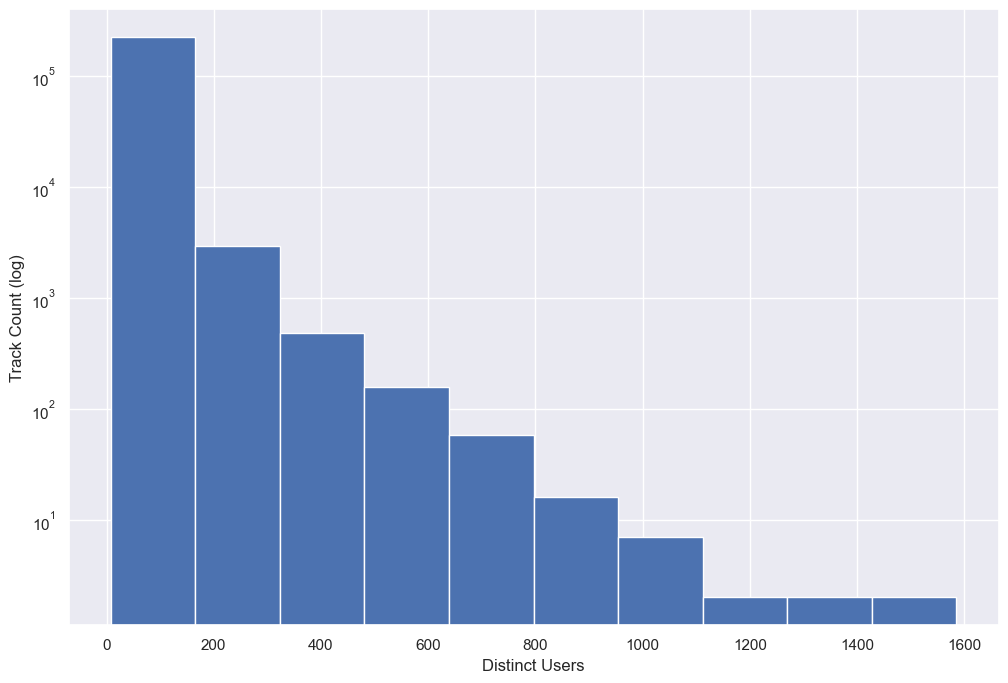

In [12]:
fig, ax = plt.subplots(figsize=(12,8))
ax.hist(track_records)
ax.set_yscale("log")
ax.set_xlabel("Distinct Users")
ax.set_ylabel("Track Count (log)")

Let's look at the distribution in percentiles again. 

In [13]:
track_records.describe(percentiles)

count    228997.000000
mean         30.140421
std          41.823156
min           8.000000
0%            8.000000
10%          10.000000
20%          12.000000
30%          13.000000
40%          15.000000
50%          17.000000
60%          21.000000
70%          26.000000
80%          36.000000
90%          59.000000
max        1585.000000
dtype: float64

Tracks are listened by 30 distinct users on the average, and 90% of them has less than 59 distinct users that played it. Further, there are some outliers: the maximum number of users is ~1600. Is this a very popular track or a dataset artifact? Let's find out.   

In [15]:
K = 10
top_by_user = track_records.iloc[track_records.argsort().values[:-(K+1):-1]]
top_by_user.name = "distinct_user_count"

# Retrieve the task information from the `dataset` handler variable
dataset.df_tracks.loc[top_by_user.index].join(top_by_user)

,track,artist_id,artist,albums_id,albums,urlSong,arousal_predicted,valence_predicted,lastfm_id,has_emotion_tags,has_social_tags,isClassic,distinct_user_count
track_id,,,,,,,,,,,,,
4868,Rolling in the Deep,504,Adele,"[1518, 18942, 64876, 66600, 80986, 93573, 9761...","['21', '19', '21 (Deluxe Edition)', 'monday_pl...",http://lyrics.wikia.com/Adele:Rolling_In_The_Deep,0.390623,-0.263898,None,None,None,True,1585
26142,We Are Young (feat. Janelle Monáe),3151,fun.,"[6907, 9619, 53139, 162664, 238945, 246098, 27...","['Some Nights', 'We Are Young', nan, 'The Best...",None,NaN,NaN,None,None,None,None,1500
11393952,Somebody That I Used to Know,3085,Gotye,"[20107, 33321, 90034, 103479, 107493, 158828, ...","['Making Mirrors (Deluxe Edition)', 'Somebody ...",http://lyrics.wikia.com/Gotye:Somebody_That_I_...,-0.383686,-0.720571,None,None,None,True,1402
16110,Get Lucky (feat. Pharrell Williams),320,Daft Punk,"[5331, 10200, 11728, 40809, 84112, 95892, 1237...","['Random Access Memories', 'Get Lucky', 'Homew...",None,NaN,NaN,None,None,None,None,1349
14034,We Found Love (feat. Calvin Harris),355,Rihanna,"[4961, 6808, 14253, 18206, 18254, 19802, 40014...","['We Found Love', 'The Official Uk Top 40 Sing...",None,NaN,NaN,None,None,None,None,1248
51176,Titanium (feat. Sia),1935,David Guetta,"[16065, 18345, 18845, 32658, 40236, 80698, 875...","['Best of...', 'Nothing but the Beat 2.0', 'No...",None,NaN,NaN,None,None,None,None,1134
28847,Get Lucky (Radio Edit) [feat. Pharrell Williams],320,Daft Punk,"[10200, 19277, 136209, 188202, 269754, 361728,...","['Get Lucky', nan, 'Random Access Memories', '...",None,NaN,NaN,None,None,None,None,1110
572665,Set Fire to the Rain,504,Adele,"[1518, 64876, 93573, 98525, 116649, 143113, 14...","['21', '21 (Deluxe Edition)', 'Rolling in the ...",http://lyrics.wikia.com/Adele:Set_Fire_To_The_...,-0.428821,-0.415065,None,None,None,False,1081
29375,Lights,4091,Ellie Goulding,"[9086, 9174, 10388, 10389, 12804, 19124, 35773...","['Halcyon (Deluxe Edition)', 'Halcyon Days', '...",http://lyrics.wikia.com/Ellie_Goulding:Lights,-0.272432,-0.724689,None,None,None,False,996


Well, these song seem pretty popular, right? But something more came up... look at position **3** and **6**: there are two different versions of *Get Lucky*. Is this something you want your model to factor in at training time? 

**Q1: How many times does a user play the same song?**

We can use the handy `user_track_count` to measure how frequently users get engaged by songs (remember to take a look at all the columns in `dataset.df_users`, there are very userful variable there).

In [16]:
avg_play_count = gb_track["user_track_count"].mean()
avg_play_count.describe(percentiles)

count    228997.000000
mean          2.577950
std           2.499551
min           1.000000
0%            1.000000
10%           1.250000
20%           1.416667
30%           1.590909
40%           1.772727
50%           2.000000
60%           2.250000
70%           2.615385
80%           3.176471
90%           4.286157
max         231.333333
Name: user_track_count, dtype: float64

On the average, a user repeats a given track ~2.6 times. Again, let's inspect our tail.

In [17]:
top_by_user = avg_play_count.iloc[avg_play_count.argsort().values[:-(K+1):-1]]
top_by_user.name = "avg_play_count"
dataset.df_tracks.loc[top_by_user.index].join(top_by_user)

,track,artist_id,artist,albums_id,albums,urlSong,arousal_predicted,valence_predicted,lastfm_id,has_emotion_tags,has_social_tags,isClassic,avg_play_count
track_id,,,,,,,,,,,,,
87233,Final Hour,14527,X-Ray Dog,"[37565, 129840, 159281]","['Night Hounds', nan, 'Harry Potter']",None,NaN,NaN,None,None,None,None,231.333333
190112,Asleep,15738,Agua de Annique,[44908],['Air'],http://lyrics.wikia.com/Agua_De_Annique:Asleep,-0.270782,0.108086,None,None,None,False,146.454545
583120,Rubik's Cube,10017,Athlete,"[194694, 206508]","['Black Swan', 'Singles 01-10']",http://lyrics.wikia.com/Athlete:Rubik%27s_Cube,-0.214444,-0.143472,TRGPGZL128F9330871,False,True,False,122.928571
11741477,Dear Darlin',9699,Olly Murs,"[152172, 680866, 699780, 1075749, 2277719, 448...","['Right Place Right Time (Deluxe Edition)', 'R...",http://lyrics.wikia.com/Olly_Murs:Dear_Darlin%27,-0.226224,-0.783971,None,None,None,False,122.300000
100848,Slow Me Down,15692,Anneke van Giersbergen,"[33336, 7100104]","['Everything Is Changing', 'Everything Is Chan...",http://lyrics.wikia.com/Anneke_Van_Giersbergen...,-0.119751,-0.049463,None,None,None,False,122.062500
102757,Entombed in Butchered Bodies,15795,Cerebral Bore,[33636],['Maniacal Miscreation'],http://lyrics.wikia.com/Cerebral_Bore:Entombed...,0.519996,-1.059996,None,None,None,False,121.181818
764985,Flesh Reflects the Madness,15795,Cerebral Bore,"[33636, 2707275]","['Maniacal Miscreation', 'The Dead Flesh Archi...",http://lyrics.wikia.com/Cerebral_Bore:Flesh_Re...,0.866363,-0.560911,None,None,None,False,119.818182
764984,Maniacal Miscreation,15795,Cerebral Bore,[33636],['Maniacal Miscreation'],http://lyrics.wikia.com/Cerebral_Bore:Maniacal...,0.742891,-0.777889,None,None,None,False,119.545455
3130123,Everything We Touch,2001,Say Lou Lou,"[174522, 5112993, 8791457, 9090677, 13248338]","[nan, 'Everything We Touch', 'Everything We To...",http://lyrics.wikia.com/Say_Lou_Lou:Everything...,-0.228184,-0.180018,None,None,None,False,116.421053


Here it is a new piece of information: the top 10 tracks by number of play counts is completely different than the one by number of distinct users.

In [18]:
# Cleanup..
del gb_track
del avg_play_count
del track_records
del top_by_user
_ = gc.collect()

### Statistics of WASABI features

The new features coming from the WASABI dataset are not available for all of our tracks, but they still cover a good part of them! Let us see what the coverage is for each of these features:

In [19]:
# NOTE that we only show statistics on train, but as train/test were uniformly
#      sampled statistics for the test set are very similar (you can check by
#      using "test.join(...)" below here
train_tracks = train.join(dataset.df_tracks, on="track_id", rsuffix="_data")

In [20]:
for feat in ['arousal_predicted', 'valence_predicted',
             'isClassic', 'has_social_tags', 'has_emotion_tags']:

    perc_tracks = np.sum(dataset.df_tracks[feat].notna())/len(dataset.df_tracks)
    perc_events = np.sum(train_tracks[feat].notna())/len(train_tracks)
    print(f"'{feat}': {round(perc_tracks,2)} tracks, {round(perc_events,2)} events")

'arousal_predicted': 0.51 tracks, 0.79 events
'valence_predicted': 0.51 tracks, 0.79 events
'isClassic': 0.51 tracks, 0.79 events
'has_social_tags': 0.17 tracks, 0.31 events
'has_emotion_tags': 0.17 tracks, 0.31 events


Similarly, topics features are available for ~69% of samples in train_tracks and song/verse embeddings cover ~78% of the samples:

In [21]:
train_topics = train_tracks.join(dataset.df_topics, on="urlSong", rsuffix="_data")
np.sum(train_topics.topics.notna())/len(train_topics)

0.6915584406176354

In [22]:
train_embs = train_tracks.join(dataset.df_song_embeddings, on="urlSong", rsuffix="_data")
np.sum(train_embs.song_embedding.notna())/len(train_embs)

0.7794887791568496

### Using topics

Topics are 60-dimensional descriptors that represent a song wrt its level of membership wrt 60 different topics. We expect songs with similar contents to have similar descriptors. Here is a simple example that shows the quasi-perfect matching of different covers of the same song:

In [53]:
descr = []
for urlSong in list(dataset.df_topics[dataset.df_topics.index.str.contains("Space_Oddity")].index):
    print(urlSong)
    descr.append(dataset.df_topics[dataset.df_topics.index==urlSong].topics.iloc[0])

http://lyrics.wikia.com/Ayreon:Space_Oddity
http://lyrics.wikia.com/Chris_Hadfield:Space_Oddity
http://lyrics.wikia.com/David_Bowie:Space_Oddity
http://lyrics.wikia.com/Helloween:Space_Oddity
http://lyrics.wikia.com/Powerman_5000:Space_Oddity
http://lyrics.wikia.com/Tangerine_Dream:Space_Oddity


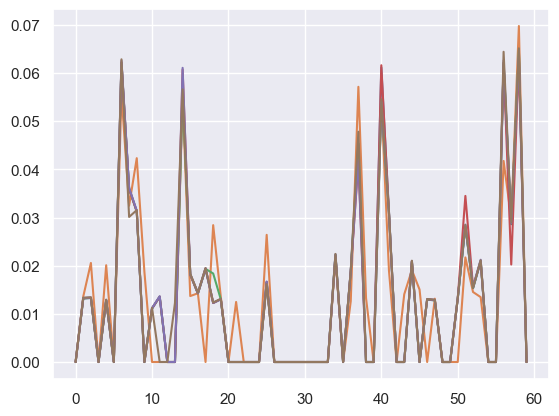

In [54]:
x = range(len(descr[0]))
for d in descr:
    plt.plot(x,d)

Here is, instead, the descriptor for a random song in the dataset plotted in black together with the above:

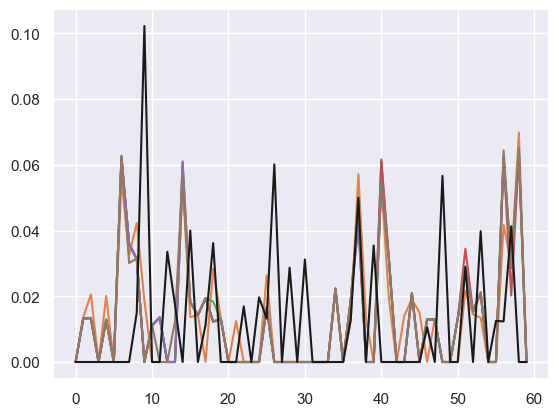

In [57]:
for d in descr:
    plt.plot(x,d)
plt.plot(x,dataset.df_topics.topics.iloc[np.random.randint(len(dataset.df_topics))], color='k')

### Using song embeddings

We can do something similar with song embeddings: here are the song embeddings for a few covers of the same song:

In [85]:
descr = []
for urlSong in list(dataset.df_song_embeddings[dataset.df_song_embeddings.index.str.contains("The_Man_Who_Sold")].index):
    print(urlSong)
    descr.append(dataset.df_song_embeddings[dataset.df_song_embeddings.index==urlSong].song_embedding.iloc[0])

http://lyrics.wikia.com/David_Bowie:The_Man_Who_Sold_The_World
http://lyrics.wikia.com/Lulu:The_Man_Who_Sold_The_World
http://lyrics.wikia.com/Midge_Ure:The_Man_Who_Sold_The_World
http://lyrics.wikia.com/Nirvana:The_Man_Who_Sold_The_World


... and in the following cell, we add embeddings from 10 random songs and plot all the pairwise distances:

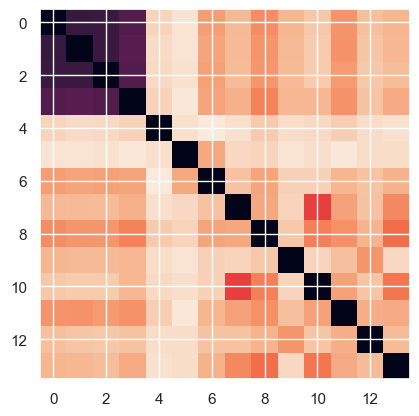

In [86]:
for i in range(10):
    descr.append(dataset.df_song_embeddings.song_embedding.iloc[
        np.random.randint(len(dataset.df_song_embeddings))])
    
descr = np.array(descr)

dists = np.linalg.norm(descr[:, None, :] - descr[None, :, :], axis=-1)
plt.imshow(dists)

### Using verse embeddings

With verse embeddings we can do something more, i.e. measure signals *within* each song. For instance, the following code loads lyrics embeddings from Guns'n'Roses' "Paradise City" and plots pairwise distances between each pair of verses (note that we'll have to download the lyrics file manually here as due to their size they were not included in the zipped version of the dataset).

In [87]:
!wget https://evalrs.object.lga1.coreweave.com/evalrs_verse_embeddings_G.parquet

--2023-07-21 12:33:49--  https://evalrs.object.lga1.coreweave.com/evalrs_verse_embeddings_G.parquet
Resolving evalrs.object.lga1.coreweave.com (evalrs.object.lga1.coreweave.com)... 216.153.56.63
Connecting to evalrs.object.lga1.coreweave.com (evalrs.object.lga1.coreweave.com)|216.153.56.63|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1284882026 (1,2G) [application/octet-stream]
Saving to: ‘evalrs_verse_embeddings_G.parquet’

evalrs_verse_embedd 100%[===================>]   1,20G  3,61MB/s    in 8m 40s  

2023-07-21 12:42:29 (2,36 MB/s) - ‘evalrs_verse_embeddings_G.parquet’ saved [1284882026/1284882026]



In [92]:
table = pq.read_table('evalrs_verse_embeddings_G.parquet')
df = table.to_pandas()
d = df[df.urlSong=='http://lyrics.wikia.com/Guns_N%27_Roses:Paradise_City'].verse_embeddings.iloc[0]
d.shape

(58368,)

**NOTE** that if you load embeddings for another song you will very likely have a different vector length! How so?

For each song, we have a verse embedding for every single line (we used `\n` as a separator). For parquet to properly store these embeddings we had to concatenate all of them into a single vector, so we have to reshape them to *n* embeddings of size 768. 

In [94]:
descr = d.reshape((-1,768))
descr.shape

(76, 768)

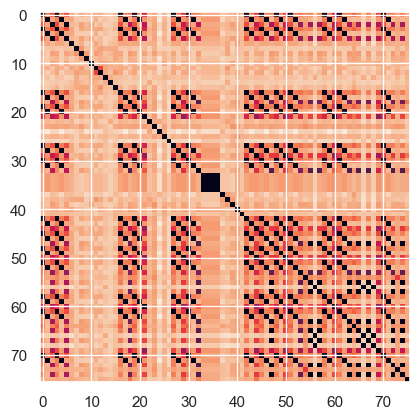

In [96]:
dists = np.linalg.norm(descr[:, None, :] - descr[None, :, :], axis=-1)
plt.imshow(dists)

You can see the verse pairwise distances above, and compare them with the text of the song below:


```
Take me down to the paradise city
Where the grass is green and the girls are pretty
Take me home (Oh, won't you please take me home?)
Take me down to the paradise city
Where the grass is green and the girls are pretty
Take me home (Oh, won't you please take me home?)
Just an urchin livin' under the street
I'm a hard case that's tough to beat
I'm your charity case so buy me somethin' to eat
I'll pay you at another time
Take it to the end of the line
Rags to riches or so they say
You gotta keep pushin' for the fortune and fame
You know it's, it's all a gamble when it's just a game
You treat it like a capital crime
Everybody's doin' their time
Take me down to the paradise city
Where the grass is green and the girls are pretty
Oh, won't you please take me home, yeah, yeah?
Take me down to the paradise city
Where the grass is green and the girls are pretty
Take me home
Strapped in the chair of the city's gas chamber
Why I'm here, I can't quite remember
The surgeon general says it's hazardous to breathe
I'd have another cigarette but I can't see
Tell me who ya gonna believe
Take me down to the paradise city
Where the grass is green and the girls are pretty
Take me home, yeah, yeah
Take me down to the paradise city
Where the grass is green and the girls are pretty
Oh, won't you please take me home, yeah?
So far away
So far away
So far away
So far away
Captain America's been torn apart
Now he's a court jester with a broken heart
He said "Turn me around and take me back to the start"
I must be losin' my mind, are you blind?
I've seen it all a million times
Take me down to the paradise city
Where the grass is green and the girls are pretty
Take me home, yeah, yeah
Take me down to the paradise city
Where the grass is green and the girls are pretty
Oh, won't you please take me home?
Take me down to the paradise city
Where the grass is green and the girls are pretty
Take me home, yeah, yeah
Take me down to the paradise city
Where the grass is green and the girls are pretty
Oh, won't you please take me home, home
Oh, I want to go, I want to know
Oh, won't you please take me home?
I want to see how good it can be
Oh, won't you please take me home?
Take me down to the paradise city
Where the grass is green and the girls are pretty
Take me home
Take me down to the paradise city
Where the grass is green and the girls are pretty
Oh, won't you please take me home?
Take me down, take me down
Oh, won't you please take me home?
I want to see how good it can be
Oh, won't you please take me home?
I want to see how good it can be
Oh, oh take me home
Take me down to the paradise city
Where the grass is green and the girls are pretty
Oh, won't you please take me home?
I want to know, I want to know
Oh, won't you please take me home?
Yeah, baby
```

In [97]:
del train_tracks
del train_topics
del train_embs
del table
del df
del descr
del dists

_ = gc.collect()

## EDA on Users 

Let's move to users now.

In [19]:
gb_user = train.groupby("user_id")

In [20]:
user_records = gb_user.size()

In [21]:
user_records.describe(percentiles=percentiles)

count    29717.000000
mean       230.488508
std        108.455895
min          9.000000
0%           9.000000
10%         75.000000
20%        126.000000
30%        168.000000
40%        204.000000
50%        237.000000
60%        268.000000
70%        299.000000
80%        332.000000
90%        372.000000
max        492.000000
dtype: float64

There are almost 30K distinct users in our dataset. The average number of songs they played is 232 with some binge listener that made it to 494.

What about their demographics?

In [22]:
train_users = train.join(dataset.df_users, on="user_id", rsuffix="_data")

In [23]:
gb_train_users = train_users.groupby("user_id")

In [24]:
gb_train_users.first().gender.value_counts(normalize=True, dropna=False)

gender
n       0.533028
m       0.331359
f       0.133795
None    0.001817
Name: proportion, dtype: float64

Only half of our users are annotated with (binary) gender, and there is a significant skew towards males.

In [25]:
users_by_country = gb_train_users.first().country.value_counts(normalize=True, sort=True, ascending=False, dropna=False)
users_by_country

country
None    0.540835
US      0.084194
RU      0.041390
DE      0.039338
UK      0.037992
          ...   
AS      0.000034
KI      0.000034
TD      0.000034
GI      0.000034
KY      0.000034
Name: proportion, Length: 160, dtype: float64

In [26]:
top_countries = gb_train_users.first().country.value_counts(dropna=True, sort=True, ascending=False)[:10]
top_countries

country
US    2502
RU    1230
DE    1169
UK    1129
PL    1044
BR     965
NL     378
FI     332
ES     304
SE     293
Name: count, dtype: int64

In [ ]:
fig, ax = plt.subplots(figsize=(12,8))
ax.bar(x=top_countries.index, height=top_countries.values)
ax.set_xlabel("Country")
ax.set_ylabel("Count")

There are 158 distinct countries but only half of the users are annotated with that information. Most of the users were logged from the United States.

In [27]:
del gb_user
del gb_train_users
del top_countries
_ = gc.collect()

## Analysis on listening events

We have explored relationships between users and tracks. But what about the playing time and hour? 

For example, one might search for any correlation between listening events and hour of the day. 

**Q0: Is there any listening pattern across hours of the day?**

Text(0, 0.5, 'Count')

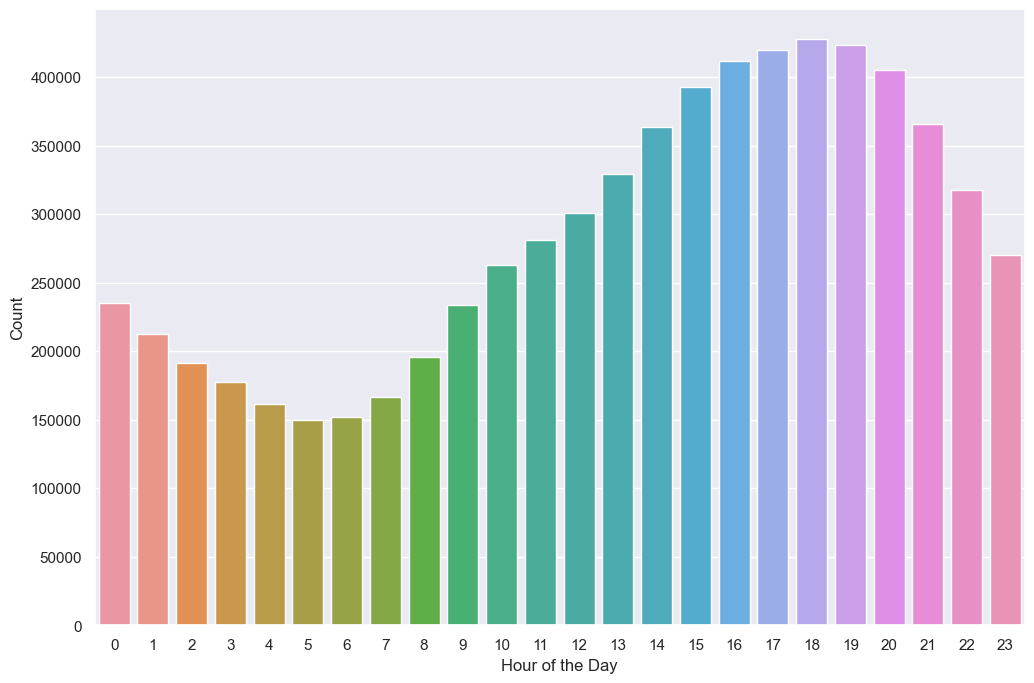

In [28]:
fig, ax = plt.subplots(figsize=(12,8))
ax = sns.countplot(data=train_users, x="hod")
ax.set_xlabel("Hour of the Day")
ax.set_ylabel("Count")

Remember that the `timestamp` attribute is in Unix time, i.e. it is absolute in terms of timezone. The chart is showing us that events are mainly located in a single timezone, as the events decrease in the morning and increase in late afternoon.   

**Q1: Is there any listening pattern across hours of the day, separately by gender?**

Text(0, 0.5, 'Count')

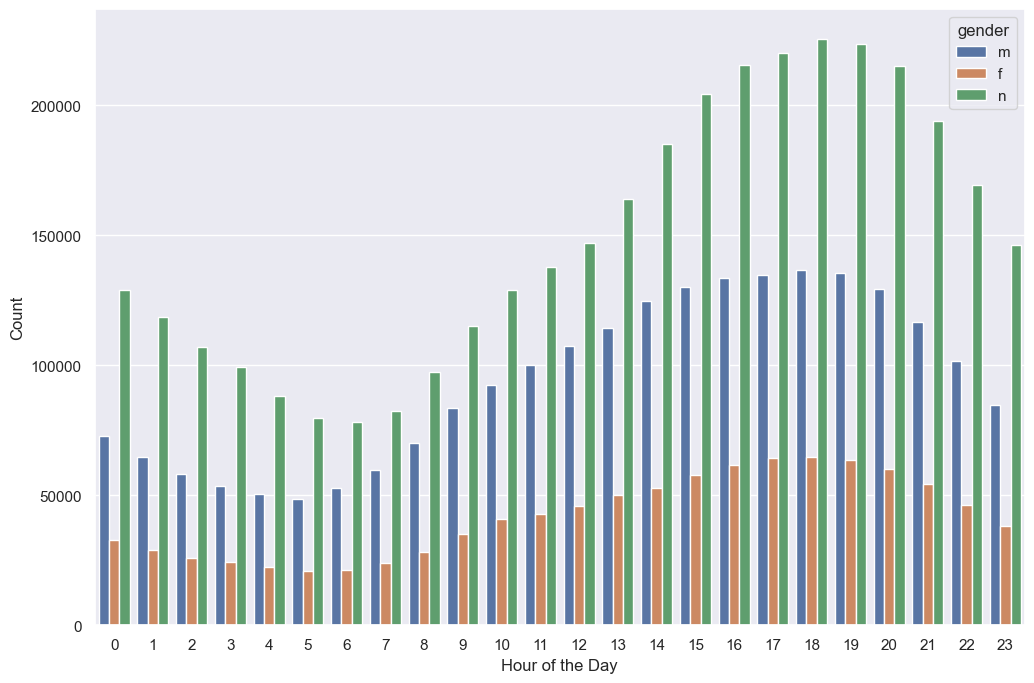

In [29]:
fig, ax = plt.subplots(figsize=(12,8))
ax = sns.countplot(data=train_users, x="hod", hue="gender")
ax.set_xlabel("Hour of the Day")
ax.set_ylabel("Count")

Judging by the chart, there seem to be no evident difference. Well, beware!